### Tutorial 4: Combining 2 fragility curves for different scenario's. 
We consider the slope reliability with a relatively thin blanket layer.

In the base case, the blanket layer has a strength, but in case of uplift the strength reduces (to 0). For the latter, a scenario is calculated with c/ph=0 in the uplift zone. 

The water level at which uplift happens is uncertain. At low water levels, the probability of uplift (and strength reduction) is rather low, whereas at high water levels, the probability of uplift is high (and thus the c/phi=0 scenario). 

#### Import necessary python packages

In [1]:
import json # for reading fragility curves in D-Stability .json format
import numpy as np # for array calculations
import scipy.stats as st # for statisitcal functions
import pandas as pd # for reading excel files
from scipy.interpolate import interp1d # for linear inter- and extrapolation outside the range
import matplotlib.pyplot as plt # for plotting

#### Load base class for Fragility curve operations

In [2]:
# A class for importing DStability Fragility curves
class DStabilityFragilityCurve:
    
    # A static method in a class can be used without the the class-data. 
    # This method densifies and extrapolates a fragility curve
    @staticmethod 
    def densify_extrapolate(x, y, xrange, xdelta, fill_value='extrapolate'):
        xnew = np.arange(xrange[0], xrange[1] + xdelta, xdelta)
        f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=fill_value)
        ynew = f(xnew)
        return xnew, ynew  
    
    def __init__(self, label, filename):
        '''
        - stores the given label
        - loads the json as raw data
        - initiates the preprocess_rawdata() method
        '''     
        self.Label = label
        with open(filename, 'r') as f:
            self.rawdata = json.load(f)
        self.preprocess_rawdata()
        
    def preprocess_rawdata(self):
        ''' 
        - preprocesses the raw data into a structure
        '''
        self.FragilityPoints = self.rawdata.get('Calculations')
        self.Stochasts = self.rawdata.get('Stochasts')
        self.Correlations = self.rawdata.get('Correlations')

        self.h = [point.get('WaterLevel') for point in self.FragilityPoints]
        self.b = [point.get('Beta') for point in self.FragilityPoints]

        # Make dictionary for translating Stochast Id to Label
        self.stochasts = {}
        for stochast in self.Stochasts:
            if stochast.get('ParameterType') == 'ModelFactor':
                self.stochasts.update({stochast.get('Id'): stochast.get('ParameterType')})
            else:
                self.stochasts.update({stochast.get('Id'): stochast.get('ParameterType') +
                                       '.' + stochast.get('Label')})

        for fragilitypoint in self.FragilityPoints:
            for contribution in fragilitypoint.get('Contributions'):
                contribution.update({'Name': self.stochasts.get(contribution.get('Stochast'))})

        # cleanup for alpha values
        self.alphas = {}
        drop_list = [correlation_item.get('Stochast2') for correlation_item in self.Correlations]
        for unique_stochast_name in set([val for key, val in self.stochasts.items()]):
            alphas = [contribution['Alpha'] for point in self.FragilityPoints
                      for contribution in point.get('Contributions')
                      if (self.stochasts[contribution.get('Stochast')] == unique_stochast_name
                          and contribution.get('Stochast') not in drop_list ) ]
            self.alphas.update({unique_stochast_name: alphas})
            # final cleanup
            self.alphas = {key: val for key, val in self.alphas.items() if val}

    def get_scenario_probability(self, file):
        '''
        Import the scenario probabliity (weights) from excel file. 
        Note the column headers match the labels of the fragility curve
        in the format P({self.Label})
        '''
        scenario_probability_data = pd.read_excel(file)
        self.scenario_h = np.array(scenario_probability_data['h'], dtype=float)
        self.scenario_p = np.array(scenario_probability_data[f'P({self.Label})'], dtype=float)
        
    def set_extrapolation_range_and_density(self, range_h, delta_h ):
        self.range_h = range_h
        self.delta_h = delta_h
          
    def densify_extrapolate_fc(self):
        # For the beta's
        self.H, self.B = DStabilityFragilityCurve.densify_extrapolate(self.h, 
                                                                      self.b, 
                                                                      self.range_h, 
                                                                      self.delta_h)
        # For the alpha's
        self.Alphas={}
        for unique_stochast_name, alphas in self.alphas.items():
            H, Alphas = DStabilityFragilityCurve.densify_extrapolate(self.h, 
                                                                     alphas, 
                                                                     self.range_h, 
                                                                     self.delta_h)
            self.alphas.update({unique_stochast_name: alphas})
            self.Alphas.update({unique_stochast_name: Alphas})
        
    def densify_extrapolate_scenario_probability(self, logarithmic=True):
        if logarithmic:
            self.scenario_p[self.scenario_p<(1e-9)] = 1e-9
            self.scenario_p[self.scenario_p>(1-1e-9)] = 1-1e-9
        
            self.H, self.P = DStabilityFragilityCurve.densify_extrapolate(self.scenario_h, 
                                                                      np.log10(self.scenario_p), 
                                                                      self.range_h, 
                                                                      self.delta_h)
            self.P = pd.Series(10.**self.P).bfill().ffill().to_numpy()
        else:
            self.H, self.P = DStabilityFragilityCurve.densify_extrapolate(self.scenario_h, 
                                                                      self.scenario_p, 
                                                                      self.range_h, 
                                                                      self.delta_h)
        

### Code for plotting

In [3]:
def plot_fragility_curves(FC_list, figures_to_plot):
    # Instantiate a figure with a specified size
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
        
    # Set the axis labels and title
    ax.set_xlabel('Water level, h')
    ax.set_ylabel(r'Reliability index, $\beta$')
    ax2.set_ylabel(r'Scenario probability, P')

    def plot_fragility_points(fig, h, b, label, color):
        # Add the fragility points to the figure
        ax.plot(h, b, color=color, marker='o', markersize=10, linestyle='none', 
                label=f'Fragility Points {label}' )
    
    def plot_extrapolated_fragility_curve(fig, h, b, label, color):
        # Add the fragility curve to the figure
        ax.plot(h, b, color=color,  marker='+', linestyle='-', 
                label=f'Extrapolated Fragility Curve {label}')

    def plot_scenario_probability(fig, h, p, label, color):
        # Add the scenario probability to the figure
        # ax2.stackplot(h, p)
        ax2.plot(h, p, color=color,  marker='None', linestyle=':', 
                 label=f'Scenario Probability {label}')
     
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    
    for i, FC in enumerate(FC_list):
        c = colors[i]
        if 1 in figures_to_plot:
            plot_fragility_points(fig, FC.h, FC.b, label=FC.Label, color=c)
            ax.legend(loc=3)
            ax.grid('on')
        if 2 in figures_to_plot:
            plot_extrapolated_fragility_curve(fig, h=FC.H, b=FC.B, label=FC.Label, color=c)
            ax.legend(loc=3)
        if 3 in figures_to_plot:
            plot_scenario_probability(fig, h=FC.H, p=FC.P, label=FC.Label, color=c)
            ax2.legend(loc=2)
    
    return fig, ax

## Load fragility curves, create DStabilityFragilityCurve objects, and save in list

In [4]:
fragility_curves_list = [ ('FC_basis','../../_static/FC_tutorial_basis.json' ),
                           ('FC_cphi0','../../_static/FC_tutorial_cphi0.json' )]
FC_list = []
for (fc_label, filename) in fragility_curves_list:
    FC = DStabilityFragilityCurve(fc_label, filename)
    FC_list.append( FC )

### Plot the fragility points

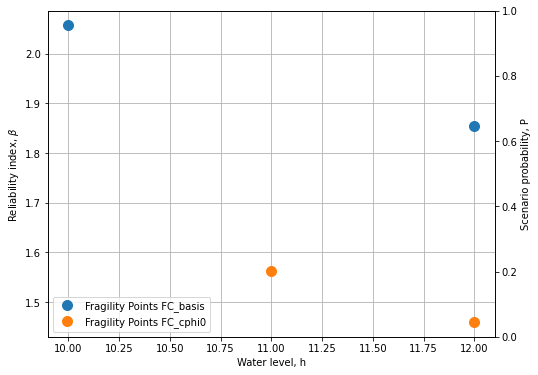

In [5]:
# Create the figure
fig, ax = plot_fragility_curves(FC_list, [1])
# Show the figure
plt.show()

### Extrapolate fragility curves linearly along the given range, with the given discretisation

In [6]:
range_h = [8,14]
delta_h = 0.05

for FC in FC_list:
    FC.set_extrapolation_range_and_density(range_h, delta_h)
    FC.densify_extrapolate_fc()

### Plot the extrapolated fragility curves

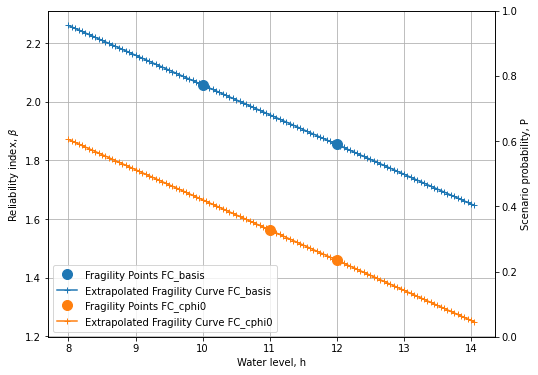

In [7]:
# Create the figure
fig, ax = plot_fragility_curves(FC_list, [1,2])
# Show the figure
plt.show()

### Load the water level dependent scenario probability and densify and extrapolate

In [8]:
for FC in FC_list:
    FC.get_scenario_probability('../../_static/ScenarioProbabilityFragilityCurvesUplift_2.xlsx')
    # Note we linearly extrapolate the logarithmic values of the probability
    FC.densify_extrapolate_scenario_probability(logarithmic=False)

### Sanity checks

In [9]:
# Check if all arrays in the list are identical
h_array_identical = all(all(array.H == FC_list[0].H) for array in FC_list)

# Check if all scenario probabilies sum to 1 with precision 0.001
sum_to_one_bool = np.abs(np.nansum( [FC.P for FC in FC_list], axis=0) -1 ) < 1e-3
scenarios_exhaustive = all(sum_to_one_bool)

if not h_array_identical:
    print("Arrays in the list are not identical. Correct the extrapolation bounds")
if not scenarios_exhaustive:
    print("Scenario probabilies do not sum to 1.0. I.e. the scenarios are not \n"
    "collectively exhaustive. Correct the scenario probabilities.")
    print(FC_list[0].H[~sum_to_one_bool])
    for FC in FC_list:
        print(FC.P[~sum_to_one_bool])

### Plot the scenario probabilities

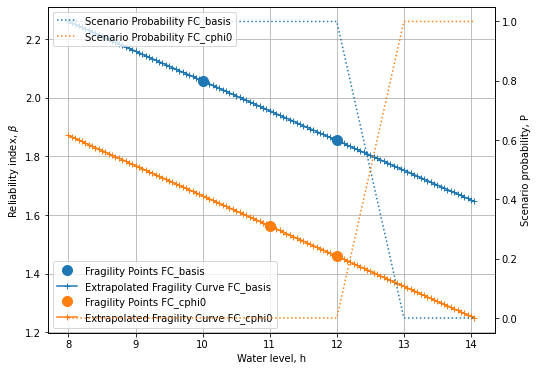

In [10]:
# Create the figure
fig, ax = plot_fragility_curves(FC_list, [1,2,3])\
# Show the figure
plt.show()

### The combination of 2 fragility curves

In [11]:
if h_array_identical and scenarios_exhaustive:
    # Combine all curves with the respective scenario probabilities 
    Pf_combined = np.sum( [FC.P * st.norm.cdf(- FC.B ) for FC in FC_list], axis=0)
    beta_combined = -1*st.norm.ppf(Pf_combined)
    h_combined = FC_list[0].H
    
    # Get weighted alpha's for all unique stochasts
    stochast_names=[]
    
    for FC in FC_list:
        stochast_names.extend(list(FC.Alphas.keys()))
    alphas_combined={}
    
    for unique_stochast_name in set(stochast_names):
        alpha_combined = np.nansum( 
            [FC.P * FC.Alphas[unique_stochast_name] for FC in FC_list], axis=0)
        alphas_combined.update({unique_stochast_name:alpha_combined})
        
    normalization_factor = np.nansum(
        [arr**2 for key, arr in alphas_combined.items()],axis=0)
    
    for key,arr in alphas_combined.items():
        arr/=np.sqrt(normalization_factor)
        
    if not all(np.abs(np.nansum(
        [arr**2 for key, arr in alphas_combined.items()],axis=0)-1) < 1e-3) :
        print('Something is wrong with the normalization of alpha-factors')
        print(alphas_combined)    

### Plot the combined fragility curve

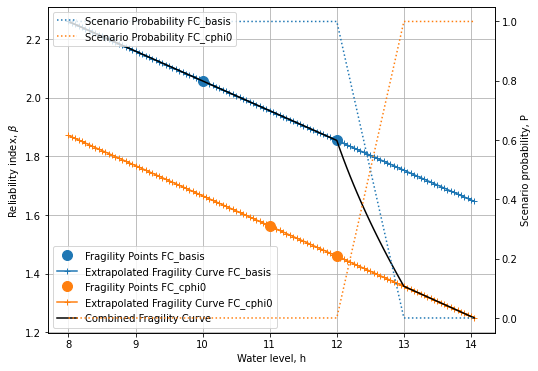

In [12]:
fig, ax = plot_fragility_curves(FC_list, [1,2,3])
ax.plot(h_combined, beta_combined, color='k', linestyle='-', label='Combined Fragility Curve')
ax.legend(loc=3)
plt.show()

### Save the combined fragility curve to json (e.g. to import in the Probabilistic Toolkit)

In [13]:
# Store the combined fragility curve to json.
alpha_values = []
stochasts = []
i=0
for stochast_name, arr in alphas_combined.items():
    alpha_values.append(arr)
    stop = False
    while not stop:
        for FC in FC_list:
            while not stop:
                for stochast in FC.Stochasts:
                    if stochast['ParameterType']+"."+stochast['Label'] == stochast_name:
                        stochast['Id'] = str(i)
                        stochasts.append(stochast)
                        stop = True
                        break
                    elif stochast['ParameterType'] == 'ModelFactor' and \
                                     stochast_name == 'ModelFactor':
                        stochasts.append(stochast)
                        stochast['Id'] = str(i)
                        stop = True
                        break
    i+=1

json_out = {"Calculations": [{"Label":"FC combined", 
                              "Beta":b, 
                              "WaterLevel":h, 
                              "Contributions":[{'Stochast': str(i),
                                                'Alpha':a} for i,a in enumerate(alphas)]
                             } for h,b,alphas in zip(h_combined, 
                                                     beta_combined, 
                                                     np.array(alpha_values).T)],
            "Stochasts":    stochasts ,
            "Correlations": []}

with open('Combined_FC.json', 'w') as f:
    json.dump(json_out, f, indent=2)
